In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig
from data_module.lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [2]:
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

def vis_gt(bev):
    bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    return vis

In [3]:
# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config_debug.yaml')
    
setup_config(cfg, setup)

# dataset list 만드는 test
DM = DataModule('nuscenes_generated', cfg.data, cfg.loader)
val_dataloader = DM.val_dataloader()
split = 'train'
data_cfg_our = DM.data_cfg
datasets = DM.get_data(split=split,
                            **data_cfg_our)

# print(f'In {split} dataset, {len(datasets)} scenes are included.')


# dataset init test
# total = 0
# for dataset in datasets:
#     total += len(dataset)

# print(f'nuscenes train has {total} data samples')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.


In [4]:
data = datasets[0].__getitem__(10)  

        'bev': torch.Size([b, 12, 200, 200])
        'view': torch.Size([b, 3, 3])
        'center': torch.Size([b, 1, 200, 200])
        'visibility': torch.Size([b, 200, 200])
        'depths': torch.Size([b, 6, 900, 1600])
        'cam_idx': torch.Size([b, 6])
        'image': torch.Size([b, 6, 3, 900, 1600])
        'intrinsics': torch.Size([b, 6, 3, 3])
        'extrinsics': torch.Size([b, 6, 4, 4])
        'sensor2sensor_mats': torch.Size([b, 6, 4, 4])
        'sensor2ego_mats': torch.Size([b, 6, 4, 4])
        'ida_mats': torch.Size([b, 6, 4, 4])

        'img_metas': list
            'token': str
            'ego2global_translation': torch.Size([3])
            'ego2global_rotation': torch.Size([4])

        'gt_boxes': [[batch_1_gts], [batch_2_gts], ..., [batch_b_gts]]
            batch_1_gts: torch.Size([n, 9])
        'gt_labels': [[batch_1_gts], [batch_2_gts], ..., [batch_b_gts]]
            batch_1_gts: torch.Size([n])

In [5]:
imgs = data['image'][0].numpy().transpose(1,2,0)
cropped_imgs = data['images_before_crop'][0].numpy().transpose(1,2,0)



In [6]:
print(imgs.shape)
print(cropped_imgs.shape)

(256, 704, 3)
(900, 1600, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


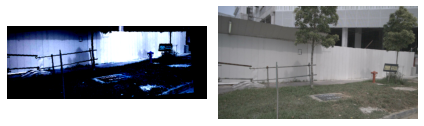

In [7]:
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(imgs)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cropped_imgs)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


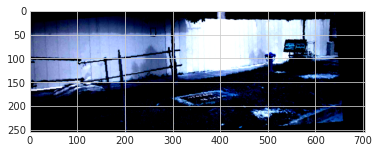

In [8]:
plt.imshow(imgs)

plt.show()

### Visualization: depth ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.86406159  2.87179971  2.90677166 ... 62.76620483 62.83993912
 63.05830383]


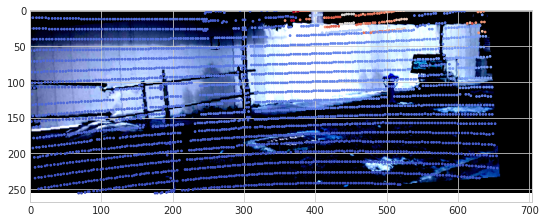

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img = np.transpose(data['image'][0].numpy(), (1,2,0))
depth = data['depths'][0].numpy()

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


# ax.axis('off')

### Visualization: 3d bbox ground truth & BEV segmentation map

In [10]:
# 3d bbox 
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}

bev_map = np.full((200, 200, 3), 255)

gt_bbox = data['gt_boxes']
gt_cls = data['gt_labels'].numpy()

# merge images

merged_imgs = merge_rgbs(data['image'].numpy())
# bev: torch.Size([200, 200, 12])
bev = vis_gt(data['bev'].numpy())

# np.unique(data['bev'][0].numpy())


In [11]:
data['gt_boxes'].shape
# data_bd[-2].shape

torch.Size([9, 9])

In [12]:
cls_mapping = {}
for i in range(10):
    cls_mapping[i] = np.random.rand((3))*255

In [13]:
from data_module.dataset.utils import *
#(0,0), top left
bev_cfg = {'h': 200, 'w': 200, 
                    'h_meters': 100.0, 'w_meters': 100.0, 'offset': 0.0}
meter2pix = get_bev_meter2pix_matrix(bev_cfg)

In [14]:
def rotate_points_along_z(points, angle):
    """
    Args:
        points: (B, N, 3 + C)
        angle: (B), angle along z-axis, angle increases x ==> y
    Returns:
    """
    cosa = np.cos(angle)
    sina = np.sin(angle)
    zeros = np.zeros(points.shape[0])
    ones = np.ones(points.shape[0])
    rot_matrix = np.stack(
        (cosa, sina, zeros, -sina, cosa, zeros, zeros, zeros, ones),
        axis=1).reshape(-1, 3, 3)
    points_rot = np.matmul(points[:, :, 0:3], rot_matrix)
    points_rot = np.concatenate((points_rot, points[:, :, 3:]), axis=-1)
    return points_rot


def get_bev_lines(corners):
    return [[[corners[i, 0], corners[(i + 1) % 4, 0]],
             [corners[i, 1], corners[(i + 1) % 4, 1]]] for i in range(4)]

def get_corners(boxes3d):
    """
        7 -------- 4
       /|         /|
      6 -------- 5 .
      | |        | |
      . 3 -------- 0
      |/         |/
      2 -------- 1
    Args:
        boxes3d:  (N, 7) [x, y, z, dx, dy, dz, heading],
            (x, y, z) is the box center
    Returns:
    """
    template = (np.array((
        [1, 1, -1],
        [1, -1, -1],
        [-1, -1, -1],
        [-1, 1, -1],
        [1, 1, 1],
        [1, -1, 1],
        [-1, -1, 1],
        [-1, 1, 1],
    )) / 2)

    corners3d = np.tile(boxes3d[:, None, 3:6],
                        [1, 8, 1]) * template[None, :, :]
    corners3d = rotate_points_along_z(corners3d.reshape(-1, 8, 3),
                                      boxes3d[:, 6]).reshape(-1, 8, 3)
    corners3d += boxes3d[:, None, 0:3]

    return corners3d

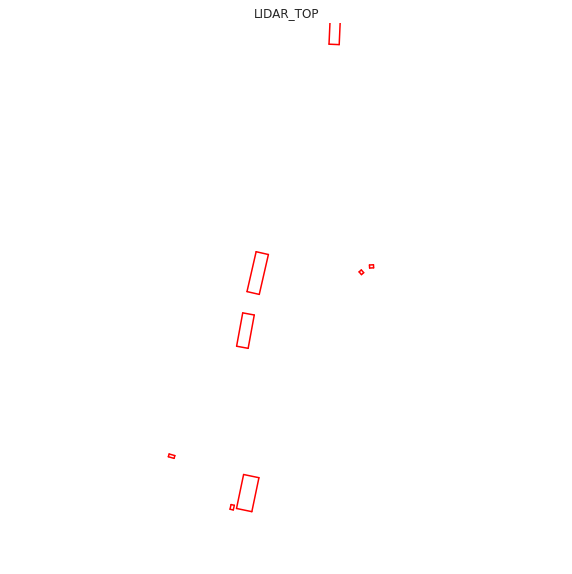

In [15]:
import matplotlib.patches as patches

bev_map = np.full((200, 200), 255)


gt_corners = []
for i in range(len(gt_bbox)):
    box = gt_bbox[i].numpy()
    if np.linalg.norm(box[:2]) <= 60:
        corners = get_corners(box[None])[0]
        gt_corners.append(corners)


plt.figure(figsize=(10, 10))

# Set BEV attributes
plt.title('LIDAR_TOP')
plt.axis('equal')
plt.axis('off')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

for corners in gt_corners:
    lines = get_bev_lines(corners)
    for line in lines:
        plt.plot([-x for x in line[1]],
                    line[0],
                    c='r',
                    label='ground truth')



(-0.5, 199.5, 199.5, -0.5)

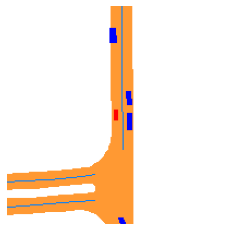

In [16]:
np.unique(data['bev'].numpy())
plt.imshow(bev)
plt.axis('off')

In [17]:
merged_imgs.shape

(512, 2112, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2111.5, 511.5, -0.5)

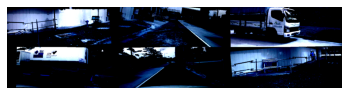

In [18]:
plt.imshow(merged_imgs)
plt.axis('off')